# Logistic Regression vs Bayesian Classifier

In [1]:
# importing required libraries
library(ggplot2)
library(reshape2)
library(mvtnorm)

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'reshape2' was built under R version 3.4.4"Warning message:
"package 'mvtnorm' was built under R version 3.4.4"

In [2]:
# loading training data and testing data 
train = read.csv(file='Task1E_train.csv')
test = read.csv(file='Task1E_test.csv')
head(train)

x1,x2,y
-0.4367052,3.171451,-1
5.1048972,1.227815,1
3.9974518,1.049502,1
2.5354540,1.242902,1
4.2624556,2.551909,1
1.5505866,2.595164,-1


In [3]:
bayesian_classifier = function(train, test, c0, c1, p0, p1, sigma0, sigma1){
    
    train.data = train[,1:2]
    train.y = train[,3]
    test.data = test[,1:2]
    test.y = test[,3]
    
    
    # Calculate class probabilities:
    p0.hat = sum(train.y == c0 )/nrow(train)
    p1.hat = 1 - p0.hat

    # Estimate class means:
    mu0.hat = colMeans(train.data[train.y==c0,])
    mu1.hat = colMeans(train.data[train.y==c1,])

    # class covariance matrices:
    sigma0.hat = var(train.data[train.y==c0,])
    sigma1.hat = var(train.data[train.y==c1,])
    
    
    # shared covariance matrix:
    sigma.hat = p0.hat * sigma0.hat + p1.hat * sigma1.hat

    # calculate posteriors:
    pos0 = p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    pos1 = p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

    # calculate predictions:
    train.predict = ifelse(pos0 > pos1, c0, c1)
    test.predict = ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > 
                           p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    # calculate training and test error:
    # training error = false predictions / total data points for training data
    train.error = (nrow(train.data) - sum(train.y==train.predict))/ nrow(train.data)

    # test error = false predictions / total data points for test data
    test.error = (nrow(train.data) - sum(train.y==test.predict))/nrow(train.data)
    return (test.error)

}

In [4]:
# auxiliary function that predicts class labels
predict = function(w, X, c0, c1){
    sig = sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost = function (w, X, T, c0){
    sig = sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid = function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}


In [5]:
logistic_regression = function(train, test, c0, c1, t.max, learning.rate, epsilon){
    
    t = 1 # iteration counter
    stop = FALSE
    
    train.data = train[,1:2]
    train.y = train[,3]
    test.data = test[,1:2]
    test.y = test[,3]
    
    
    # renaming to for the easy understanding of code
    X = as.matrix(train.data)
    T = ifelse(train.y==c0,0,1)
    
    # weights matrix to update with updated weights
    W = matrix(,nrow=t.max, ncol=(ncol(X)+1))
    W[1,] = runif(ncol(W)) # initial weight

    # project data using the sigmoid function
    Y = sigmoid(W[1,],X)
    
    costs = data.frame('t'=1:t.max)  # to trace the cost in each iteration
    costs[1, 'cost'] = cost(W[1,],X,T, c0)


    while(!stop){
        # check termination criteria:
        stop = t >= t.max | cost(W[t,],X,T, c0)<=epsilon

        # shuffle data:
        train.index = sample(1:nrow(train.data), nrow(train.data), replace = FALSE)
        X = X[train.index,]
        T = T[train.index]

        # for each datapoint:
        for (i in 1:nrow(train.data)){
            
            # check termination criteria:
            if (t >= t.max | cost(W[t,],X,T, c0) <=epsilon) {stop=TRUE;break}

            Y = sigmoid(W[t,],X)

            # Update the weights
            W[(t+1),] = W[t,] - learning.rate * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(t+1), 'cost'] = cost(W[t,],X,T, c0)

            # update the counter:
            t = t + 1

            # decrease learning rate:
            learning.rate = learning.rate * 0.999
        }
    }
    
    costs = costs[1:t, ] # remove the NaN tail of the vector (in case of early stopping)

    # final result:
    w = W[t,]
    
    # calculate predictions:
    train.predict = predict(w,train.data,c0,c1)
    test.predict = predict(w,test.data,c0,c1)

    # calculate training and test error(missclassifications)
    train.error = (nrow(train.data) - sum(train.y==train.predict))/ nrow(train.data)

    # test error = false predictions / total data points for test data
    test.error = (nrow(test.data) - sum(test.y==test.predict))/nrow(test.data)
    return (test.error)   
}

In [6]:
## initialization of parameters
c0 = +1; c1 = -1 # class labels

# initializations for Bayesian Classifier
mu0 = c(4.5, 0.5); p0 = 0.60
mu1 = c(1.0, 4.0); p1 = 1 - p0
sigma = matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 = sigma
sigma1 = sigma


# initilizations for LR
t.max <- 1000 # maximum number of iterations
learning.rate <- 0.01
epsilon <- 0.01 # a threshold on the cost (to terminate the process)


In [7]:
get_sample = function (data,size){
    
    indices = sample(1:nrow(data),size,replace =F)
    return(indices)
    
}


seq = seq(from = 5, to = nrow(train), by = 5)

error = data.frame('trainSize'=numeric(),
                   'Bayesian.error' = double(),
                   'LR.error'  = double())

i = 1 # matrix index to store test errors
for (size in seq){
    train.sample = train[get_sample(train, size),]
    test.sample = test[get_sample(test, size),]
    
    error[i, 1] = size
    error[i, 2] = bayesian_classifier(train.sample, test.sample, c0, c1, p0, p1, sigma0, sigma1)
    error[i, 3] = logistic_regression(train.sample, test.sample, c0, c1, t.max, learning.rate, epsilon)
    i = i + 1
}


tail(error)

,trainSize,Bayesian.error,LR.error
95,475,0.4336842,0.01684211
96,480,0.4458333,0.01458333
97,485,0.4474227,0.01855670
98,490,0.4224490,0.01428571
99,495,0.4262626,0.01414141
100,500,0.4640000,0.01400000


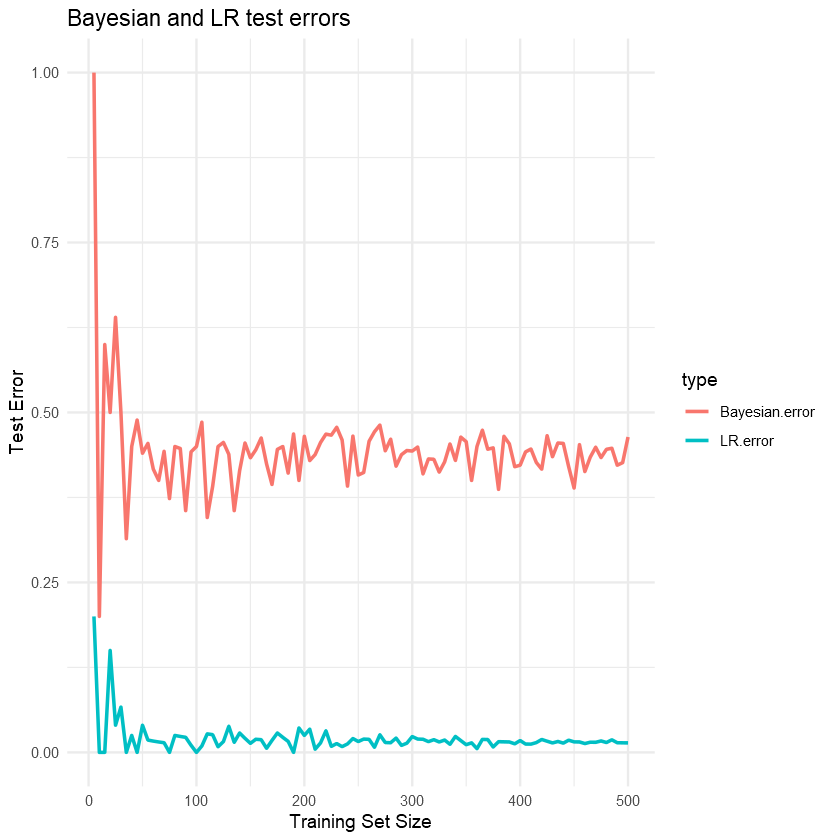

In [8]:
m.error = melt(as.data.frame(error), id='trainSize')
names(m.error) = c('trainSize','type','error')

ggplot(data=m.error, aes(x = trainSize, y = error, color=type)) + geom_line(size=.75) + 
        labs(title='Bayesian and LR test errors', x = "Training Set Size", y = "Test Error") +  theme_minimal()

### Report

i. When the training set size is increased, both the errors reached zero and increased suddenly to a ighest point and then became reduced to a optimal error. Upon further increase of training size, both errors kept fluctuating but the difference is minimal.

ii. In this case Logistic regression is most suitable irrespective of the data set size.